/tmp/ipykernel_1726/983640589.py:59: RuntimeWarning: overflow encountered in matmul
  term1 = S_next @ M @ np.linalg.inv(D) @ M.T @ S_next
/tmp/ipykernel_1726/983640589.py:59: RuntimeWarning: invalid value encountered in matmul
  term1 = S_next @ M @ np.linalg.inv(D) @ M.T @ S_next
/tmp/ipykernel_1726/983640589.py:60: RuntimeWarning: invalid value encountered in matmul
  term2 = H.T @ S_next + S_next @ H + C
/tmp/ipykernel_1726/983640589.py:84: RuntimeWarning: overflow encountered in matmul
  term1 = S_next @ M @ np.linalg.inv(A) @ M.T @ S_next
/tmp/ipykernel_1726/983640589.py:84: RuntimeWarning: invalid value encountered in matmul
  term1 = S_next @ M @ np.linalg.inv(A) @ M.T @ S_next
/tmp/ipykernel_1726/983640589.py:85: RuntimeWarning: invalid value encountered in matmul
  term2 = H.T @ S_next + S_next @ H + C


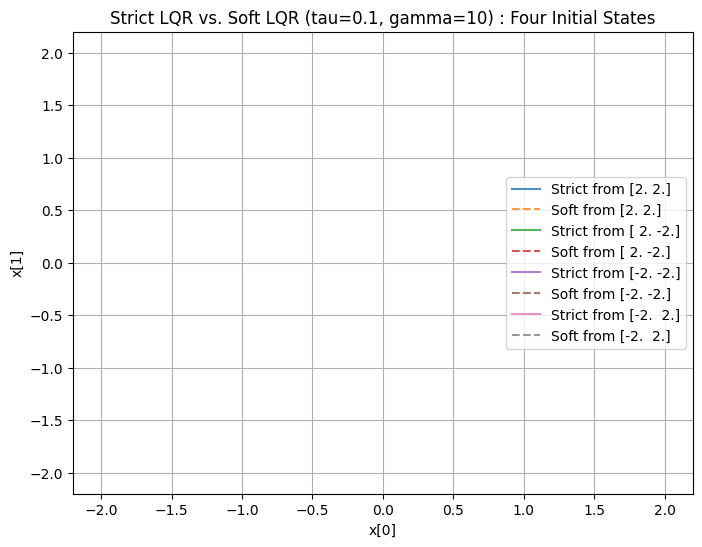

In [16]:
import numpy as np
import matplotlib.pyplot as plt

##############################################################################
#  (1)  定义线性系统与 LQR 模型：含 tau, gamma 用于软性 LQR
##############################################################################
# 系统维度与基本参数
d = 2          # 状态维度
m = 2          # 控制维度
T = 1.0        # 终止时间
N = 20         # 时间离散步数
dt = T / N     # 每步长度

# 系统矩阵（示例，和文档中一致）
H = np.array([
    [1.0, 0.8],
    [0.1, 0.3]
])
M = np.array([
    [0.3, 0.1],
    [0.8, 1.0]
])
sigma = 0.5 * np.eye(d)  # 扩散系数

# 代价矩阵
C = 10.0 * np.eye(d)
D = 0.005 * np.eye(m)
R = 100.0 * np.eye(d)

# 软性 LQR 的正则参数
tau = 0.1    # 熵正则强度
gamma = 10.0 # 先验 N(0, gamma^2 I) 的方差参数

# 需要比较的初始状态
x0_list = [
    np.array([ 2.0,  2.0]),
    np.array([ 2.0, -2.0]),
    np.array([-2.0, -2.0]),
    np.array([-2.0,  2.0]),
]


##############################################################################
#  (2)  分别求解【严格 LQR】与【软性 LQR】的黎卡提方程
##############################################################################
def solve_strict_riccati(H, M, D, C, R, T, N):
    """
    解严格 LQR 对应的 Riccati 方程:
      S'(t) = S M D^{-1} M^T S - (H^T S + S H + C),   S(T)=R.
    用向后欧拉(Backward-Euler)做离散逼近。
    """
    dt = T / N
    S_array = np.zeros((N+1, d, d))
    S_array[-1] = R  # 终端条件

    for i in range(N-1, -1, -1):
        S_next = S_array[i+1]
        # 计算 dS/dt
        term1 = S_next @ M @ np.linalg.inv(D) @ M.T @ S_next
        term2 = H.T @ S_next + S_next @ H + C
        dS = term1 - term2
        # 反向一步
        S_array[i] = S_next - dt * dS

    return S_array

def solve_soft_riccati(H, M, D, C, R, T, N, tau, gamma):
    """
    解【软性 LQR】的 Riccati 方程:
      S'(t) = S M (D + tau/(2 gamma^2) I)^{-1} M^T S - [H^T S + S H + C],
      S(T) = R.
    同样用向后欧拉做离散逼近。
    """
    dt = T / N
    S_array = np.zeros((N+1, d, d))
    S_array[-1] = R

    # A = D + tau/(2 gamma^2) I
    A = D + (tau / (2.0 * gamma**2)) * np.eye(m)

    for i in range(N-1, -1, -1):
        S_next = S_array[i+1]
        # 计算 dS/dt
        term1 = S_next @ M @ np.linalg.inv(A) @ M.T @ S_next
        term2 = H.T @ S_next + S_next @ H + C
        dS = term1 - term2
        S_array[i] = S_next - dt * dS

    return S_array

S_strict = solve_strict_riccati(H, M, D, C, R, T, N)
S_soft   = solve_soft_riccati(H, M, D, C, R, T, N, tau, gamma)


##############################################################################
# (3)  定义最优控制：严格 LQR 是确定性；软性 LQR 要从分布中采样
##############################################################################
def strict_control(x, S):
    """
    严格 LQR 的最优确定性反馈:   a^*(t,x) = -D^{-1} M^T S(t) x
    """
    return - np.linalg.inv(D) @ M.T @ S @ x

def soft_control_sample(x, S, tau, gamma):
    """
    软性 LQR 的最优控制分布 N(mean, cov):
      mean = - (D + tau/(2 gamma^2) I)^{-1} M^T S x
      cov  = tau * (D + tau/(2 gamma^2) I)^{-1}
    这里要“采样”得到实际动作 a。
    """
    A = D + (tau / (2.0 * gamma**2)) * np.eye(m)
    mean = - np.linalg.inv(A) @ M.T @ S @ x
    cov  = tau * np.linalg.inv(A)
    return np.random.multivariate_normal(mean, cov)


##############################################################################
# (4)  在相同噪声下模拟并作图
##############################################################################
def simulate_trajectories(x0, S_strict_arr, S_soft_arr,
                          H, M, sigma, tau, gamma, dt, N, rng_seed=42):
    """
    从同一个 Wiener 过程样本 (same noise) 出发，
    分别生成 “严格 LQR” 与 “软性 LQR” 的系统状态轨迹。
    """
    np.random.seed(rng_seed)
    dW = np.random.randn(N, d) * np.sqrt(dt)

    x_strict_traj = np.zeros((N+1, d))
    x_soft_traj   = np.zeros((N+1, d))

    x_strict_traj[0] = x0
    x_soft_traj[0]   = x0

    for i in range(N):
        # 取对应的 S(t_i)
        S_st = S_strict_arr[i]
        S_sf = S_soft_arr[i]

        # 严格 LQR
        u_strict = strict_control(x_strict_traj[i], S_st)
        dx_strict = (H @ x_strict_traj[i] + M @ u_strict)*dt + sigma @ dW[i]
        x_strict_traj[i+1] = x_strict_traj[i] + dx_strict

        # 软性 LQR (要随机采样控制)
        u_soft = soft_control_sample(x_soft_traj[i], S_sf, tau, gamma)
        dx_soft = (H @ x_soft_traj[i] + M @ u_soft)*dt + sigma @ dW[i]
        x_soft_traj[i+1] = x_soft_traj[i] + dx_soft

    return x_strict_traj, x_soft_traj


# 现在跑四个不同的初始状态，用 tau=0.1, gamma=10 比较
plt.figure(figsize=(8,6))
for x0 in x0_list:
    xs_strict, xs_soft = simulate_trajectories(
        x0, S_strict, S_soft, H, M, sigma, tau, gamma, dt, N
    )
    plt.plot(xs_strict[:,0], xs_strict[:,1], label=f"Strict from {x0}", alpha=0.8)
    plt.plot(xs_soft[:,0],   xs_soft[:,1],   '--', label=f"Soft from {x0}", alpha=0.8)

plt.title("Strict LQR vs. Soft LQR (tau=0.1, gamma=10) : Four Initial States")
plt.xlabel("x[0]")
plt.ylabel("x[1]")
plt.grid(True)
plt.legend()
plt.show()
